In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [15]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        action_probs = np.zeros(nA)
        # find greedy action
        greedy_A = np.argmax(Q[observation])
        # probability of taking a random step
        explore_prob = epsilon / nA
        action_probs.fill(explore_prob)
        
        # set probability of greedy action as 1-epsilon
        action_probs[greedy_A] = 1 - epsilon + (epsilon / nA)
        return action_probs
    
    return policy_fn

In [18]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    nA = env.action_space.n
    for i_episode in range(1,num_episodes+1):
        
        # mark progress
        if i_episode % 1000:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an episode
        episode = []
        state = env.reset()
        for t in range(100):
            # choose an action from the current policy
            action_probs = policy(state)
            action = np.random.choice(np.arange(nA), p=action_probs)
            # take a step in the environment
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            # check if episode is finished
            if done:
                break
            state = next_state
            
        # policy evaluation + improvement 
        state_actions = set([tuple((x[0],x[1])) for x in episode])
        for s,a in state_actions:
            # find first occurrence of state-action pair
            first_idx = next(i for i,x in enumerate(episode) if (x[0],x[1]) == (s,a))
            # get return from that point
            G = sum([x[2] * (discount_factor**i) for i,x in enumerate(episode[first_idx:])])
            # increment return, count for s-a pair
            returns_sum[(s,a)] += G
            returns_count[(s,a)] += 1.0
            Q[s][a] = returns_sum[(s,a)] / returns_count[(s,a)]
            # policy improvement
            policy = make_epsilon_greedy_policy(Q, epsilon, nA)
    
    
    return Q, policy

In [19]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499999/500000.

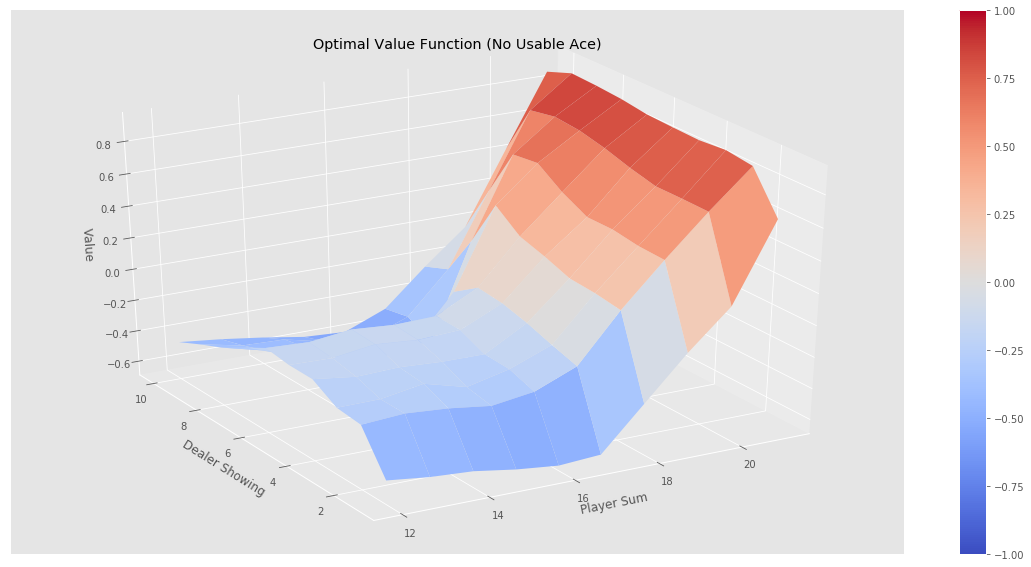

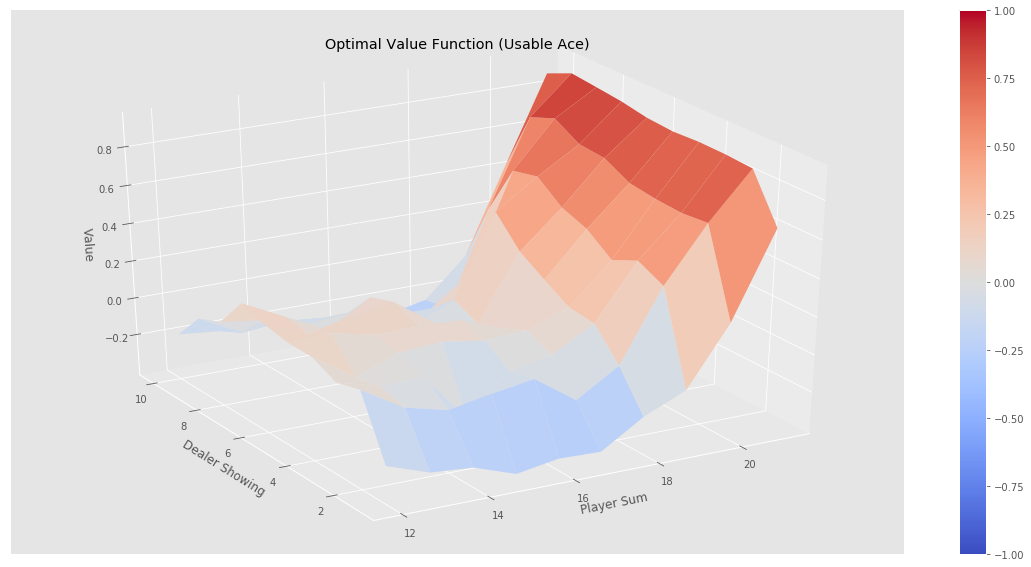

In [20]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")